## Important imports

In [55]:
import os
import json
import pickle
import csv
import calendar
import math
import csv
import copy
import pandas as pd
import numpy as np
import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib.ticker import  MultipleLocator, FormatStrFormatter
from scipy.interpolate import spline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import estimate_bandwidth, MeanShift
from sklearn.manifold import TSNE
from keras.models import load_model
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Adagrad
from keras import backend as K
from keras.layers import Merge
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Reshape, Activation, Dropout
from keras.callbacks import ModelCheckpoint

# Display plots inline
%matplotlib inline

# Fix random seed for reproducibility
np.random.seed(42)

## Some useful utilities

In [20]:
# Coordinates of Porto's city centre
porto = [41.1579, -8.6291]

In [21]:
def np_haversine(latlon1, latlon2):
    """
    Numpy version of the Haversine function to calculate distances between two sets of points.
    
    """
    lat1 = latlon1[:, 0]
    lon1 = latlon1[:, 1]
    lat2 = latlon2[:, 0]
    lon2 = latlon2[:, 1]
    
    REarth = 6371
    lat = np.abs(lat1 - lat2) * np.pi / 180
    lon = np.abs(lon1 - lon2) * np.pi / 180
    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180
    a = np.sin(lat / 2) * np.sin(lat / 2) + np.cos(lat1) * np.cos(lat2) * np.sin(lon / 2) * np.sin(lon / 2)
    d = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return REarth * d

In [22]:
def tf_haversine(latlon1, latlon2):
    """
    Tensorflow version of the Haversine function to calculate distances between two sets of points.
    """
    lat1 = latlon1[:, 0]
    lon1 = latlon1[:, 1]
    lat2 = latlon2[:, 0]
    lon2 = latlon2[:, 1]

    REarth = 6371
    lat = tf.abs(lat1 - lat2) * np.pi / 180
    lon = tf.abs(lon1 - lon2) * np.pi / 180
    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180
    a = tf.sin(lat / 2) * tf.sin(lat / 2) + tf.cos(lat1) * tf.cos(lat2) * tf.sin(lon / 2) * tf.sin(lon / 2)
    d = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    return REarth * d

In [23]:
def get_clusters(coords):
    """
    Estimate clusters for the given list of coordinates.
    """
    # reduce the spatial dataset by rounding up the coordinates to the 4th decimal
    clusters = pd.DataFrame({
        'approx_latitudes': coords[:,0].round(4),
        'approx_longitudes': coords[:,1].round(4)
    })
    clusters = clusters.drop_duplicates(['approx_latitudes', 'approx_longitudes'])
    clusters = clusters.as_matrix()
    
    # Further reduce the number of clusters
    bandwidth = estimate_bandwidth(clusters, quantile=0.0002)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(clusters)
    return ms.cluster_centers_

## Loading and preprocessing of data

In [24]:
class Data:
    """
    Class for holding a number of datasets and metadata.
    """
    pass


In [25]:
def convert_coordinates(string):
    """
    Loads list of coordinates from given string and swap out longitudes & latitudes.

    """
    return [(lat, long) for (long, lat) in json.loads(string)]

In [26]:
def random_truncate(coords):
    """
    Randomly truncate the end of the trip's polyline points to simulate partial trips.

    """
    
    # There's no need to truncate if there's not more than one item
    if len(coords) <= 1:
        return coords
    
    # Pick a random number of items to be removed from the list.
    # (We do "-1" to ensure we have at least one item left)
    n = np.random.randint(len(coords)-1)

    if n > 0:
        # Return the list without its last n items
        return coords[:-n]
    else:
        # No truncation needed in this case
        return coords

In [27]:
def encode_feature(feature, train, test):
    """
    Encode the labels for the given feature across both the train and test datasets.
    
    """
    encoder = LabelEncoder()
    train_values = train[feature].copy()
    test_values = test[feature].copy()
    # Replace missing values with 0's so we can later encode them
    train_values[np.isnan(train_values)] = 0
    test_values[np.isnan(test_values)] = 0
    # Fit the labels across all possible values in both datasets
    encoder.fit(pd.concat([train_values, test_values]))
    # Add new column to the datasets with encoded values
    train[feature + '_ENCODED'] = encoder.transform(train_values)
    test[feature + '_ENCODED'] = encoder.transform(test_values)
    return encoder

In [28]:
def extract_features(df):
    """
    Extract some features from the original columns in the given dataset.
    
    """
    # Convert polyline values from strings to list objects
    df['POLYLINE'] = df['POLYLINE'].apply(convert_coordinates)
    # Extract start latitudes and longitudes
    df['START_LAT'] = df['POLYLINE'].apply(lambda x: x[0][0])
    df['START_LONG'] = df['POLYLINE'].apply(lambda x: x[0][1])
    # Extract quarter hour of day
    datetime_index = pd.DatetimeIndex(df['TIMESTAMP'])
    df['QUARTER_HOUR'] = datetime_index.hour * 4 + datetime_index.minute / 15   
    # Extract day of week
    df['DAY_OF_WEEK'] = datetime_index.dayofweek
    # Extract week of year
    df['WEEK_OF_YEAR'] = datetime_index.weekofyear - 1
    # Extract trip duration (GPS coordinates are recorded every 15 seconds)
    df['DURATION'] = df['POLYLINE'].apply(lambda x: 15 * len(x))

In [29]:
def remove_outliers(df, labels):
    """
    Remove some outliers that could otherwise undermine the training's results.
    
    """
    # Remove trips that are either extremely long or short (potentially due to GPS recording issue)
    indices = np.where((df.DURATION > 60) & (df.DURATION <= 2 * 3600))
    df = df.iloc[indices]
    labels = labels[indices]
    
    # Remove trips that are too far away from Porto (also likely due to GPS issues)
    bounds = (  # Bounds retrieved using http://boundingbox.klokantech.com
        (41.052431, -8.727951),
        (41.257678, -8.456039)
    )
    indices = np.where(
        (labels[:,0]  >= bounds[0][0]) &
        (labels[:,1] >= bounds[0][1]) &
        (labels[:,0]  <= bounds[1][0]) &
        (labels[:,1] <= bounds[1][1])
    )
    df = df.iloc[indices]
    labels = labels[indices]
    
    return df, labels

In [30]:
def load_data():
    """
    Loads data from CSV files
    """
    datasets = []
    for name in ['train', 'test']:
        # Load original CSV file
        csv_file = '%s.csv' % name
        df = pd.read_csv(csv_file)
        # Ignore items that are missing data
        df = df[df['MISSING_DATA'] == False]
        # Ignore items that don't have polylines
        df = df[df['POLYLINE'] != '[]']
        # Delete the now useless column to save a bit of memory
        df.drop('MISSING_DATA', axis=1, inplace=True)
        # Delete an useless column (all values are 'A')
        df.drop('DAY_TYPE', axis=1, inplace=True)
        # Fix format of timestamps
        df['TIMESTAMP'] = df['TIMESTAMP'].astype('datetime64[s]')
        # Extract some new features
        extract_features(df)
        datasets.append(df)
    
    train, competition_test = datasets

    # Encode some features
    client_encoder = encode_feature('ORIGIN_CALL', train, competition_test)
    taxi_encoder = encode_feature('TAXI_ID', train, competition_test)
    stand_encoder = encode_feature('ORIGIN_STAND', train, competition_test)

    # Randomly truncate the trips to simulate partial trips like in the competition's test dataset.
    train['POLYLINE_FULL'] = train['POLYLINE'].copy() 
    train['POLYLINE'] = train['POLYLINE'].apply(random_truncate)

    # The labels are the last polyline coordinates, i.e. the trips' destinations.
    train_labels = np.column_stack([
        train['POLYLINE_FULL'].apply(lambda x: x[-1][0]),
        train['POLYLINE_FULL'].apply(lambda x: x[-1][1])
    ])
        
    # Remove some outliers
    train, train_labels = remove_outliers(train, train_labels)

    # Gather some metadata that will later be useful during training
    metadata = {
        'n_quarter_hours': 96,  # Number of quarter of hours in one day (i.e. 24 * 4).
        'n_days_per_week': 7,
        'n_weeks_per_year': 52,
        'n_client_ids': len(client_encoder.classes_),
        'n_taxi_ids': len(taxi_encoder.classes_),
        'n_stand_ids': len(stand_encoder.classes_),
    }
        
    # Split original train dataset into new train (98%), validation (1%) and test (1%) datasets.        
    train, validation, train_labels, validation_labels = train_test_split(train, train_labels, test_size=0.02)
    validation, test, validation_labels, test_labels = train_test_split(validation, validation_labels, test_size=0.5)
    
    data = Data()
    data.__dict__.update({
        'train': train,
        'train_labels': train_labels,
        'validation': validation,
        'validation_labels': validation_labels,
        'test': test,
        'test_labels': test_labels,
        'competition_test': competition_test,
        'metadata': metadata,
    })
    return data

## Creating the model

In [31]:
def start_new_session():
    """
    Starts a new Tensorflow session.
    """
    
    # Make sure the session only uses the GPU memory that it actually needs
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    
    session = tf.Session(config=config, graph=tf.get_default_graph())
    K.tensorflow_backend.set_session(session)


In [32]:
def first_last_k(coords):
    """
    Returns a list with the first k and last k GPS coordinates from the given trip.
    The returned list contains 4k values (latitudes and longitudes for 2k points).
    """
    k = 5
    partial = [coords[0] for i in range(2*k)]
    num_coords = len(coords)
    if num_coords < 2*k:
        partial[-num_coords:] = coords
    else:
        partial[:k] = coords[:k]
        partial[-k:] = coords[-k:]
    partial = np.row_stack(partial)
    return np.array(partial).flatten()

In [33]:
def process_features(df):
    """
    Process the features required by our model from the given dataframe.
    Return the features in a list so that they can be merged in our model's input layer.
    """
    # Fetch the first and last GPS coordinates
    coords = np.row_stack(df['POLYLINE'].apply(first_last_k))
    # Standardize latitudes (odd columns) and longitudes (even columns)
    latitudes = coords[:,::2]
    coords[:,::2] = scale(latitudes)
    longitudes = coords[:,1::2]
    coords[:,1::2] = scale(longitudes)
    
    return [
        df['QUARTER_HOUR'].as_matrix(),
        df['DAY_OF_WEEK'].as_matrix(),
        df['WEEK_OF_YEAR'].as_matrix(),
        df['ORIGIN_CALL_ENCODED'].as_matrix(),
        df['TAXI_ID_ENCODED'].as_matrix(),
        df['ORIGIN_STAND_ENCODED'].as_matrix(),
        coords,
    ]

In [34]:
def create_model(metadata, clusters):
    """
    Creates all the layers for our neural network model.
    """

    # Arbitrary dimension for all embeddings
    embedding_dim = 10

    # Quarter hour of the day embedding
    quarter_hour = Sequential()
    quarter_hour.add(Embedding(metadata['n_quarter_hours'], embedding_dim, input_length=1))
    quarter_hour.add(Reshape((embedding_dim,)))

    # Day of the week embedding
    day_of_week = Sequential()
    day_of_week.add(Embedding(metadata['n_days_per_week'], embedding_dim, input_length=1))
    day_of_week.add(Reshape((embedding_dim,)))

    # Week of the year embedding
    week_of_year = Sequential()
    week_of_year.add(Embedding(metadata['n_weeks_per_year'], embedding_dim, input_length=1))
    week_of_year.add(Reshape((embedding_dim,)))

    # Client ID embedding
    client_ids = Sequential()
    client_ids.add(Embedding(metadata['n_client_ids'], embedding_dim, input_length=1))
    client_ids.add(Reshape((embedding_dim,)))

    # Taxi ID embedding
    taxi_ids = Sequential()
    taxi_ids.add(Embedding(metadata['n_taxi_ids'], embedding_dim, input_length=1))
    taxi_ids.add(Reshape((embedding_dim,)))

    # Taxi stand ID embedding
    stand_ids = Sequential()
    stand_ids.add(Embedding(metadata['n_stand_ids'], embedding_dim, input_length=1))
    stand_ids.add(Reshape((embedding_dim,)))

    # GPS coordinates (5 first lat/long and 5 latest lat/long, therefore 20 values)
    coords = Sequential()
    coords.add(Dense(1, input_dim=20, init='normal'))

    # Merge all the inputs into a single input layer
    model = Sequential()
    model.add(Merge([
                quarter_hour,
                day_of_week,
                week_of_year,
                client_ids,
                taxi_ids,
                stand_ids,
                coords
            ], mode='concat'))

    # Simple hidden layer
    model.add(Dense(500))
    model.add(Activation('relu'))

    # Determine cluster probabilities using softmax
    model.add(Dense(len(clusters)))
    model.add(Activation('softmax'))

    # Final activation layer: calculate the destination as the weighted mean of cluster coordinates
    cast_clusters = K.cast_to_floatx(clusters)
    def destination(probabilities):
        return tf.matmul(probabilities, cast_clusters)
    model.add(Activation(destination))

    # Compile the model
    optimizer = SGD(lr=0.01, momentum=0.9, clipvalue=1.)  # Use `clipvalue` to prevent exploding gradients
    model.compile(loss=tf_haversine, optimizer=optimizer)

    return model

## Training the model

In [35]:
def full_train(n_epochs=20, batch_size=200):
    """
    Runs the complete training process.
    """
    
    # Load initial data
    print ("Loading data...")
    data = load_data()

    # Estimate the GPS clusters
    print ("Estimating clusters...")
    clusters = get_clusters(data.train_labels)
   
    # Create model
    print ("Creating model...")
    start_new_session()
    model = create_model(data.metadata, clusters)
    
    # Run the training
    print ("Start training...")
    history = model.fit(
        process_features(data.train), data.train_labels,
        nb_epoch=n_epochs, batch_size=batch_size,
        validation_data=(process_features(data.validation), data.validation_labels)
    )
    return history

## Running

In [36]:
history = full_train()


Loading data...
Estimating clusters...
Creating model...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=20, kernel_initializer="normal")`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Start training...


C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 23534 samples, validate on 240 samples
Epoch 1/20
23534/23534 [==============================] - 102s 4ms/step - loss: 3.0805 - val_loss: 3.0650
Epoch 2/20
23534/23534 [==============================] - 100s 4ms/step - loss: 3.0780 - val_loss: 3.0619
Epoch 3/20
23534/23534 [==============================] - 98s 4ms/step - loss: 3.0751 - val_loss: 3.0586
Epoch 4/20
23534/23534 [==============================] - 98s 4ms/step - loss: 3.0709 - val_loss: 3.0532
Epoch 5/20
23534/23534 [==============================] - 98s 4ms/step - loss: 3.0631 - val_loss: 3.0408
Epoch 6/20
23534/23534 [==============================] - 98s 4ms/step - loss: 3.0435 - val_loss: 3.0064
Epoch 7/20
23534/23534 [==============================] - 99s 4ms/step - loss: 2.9741 - val_loss: 2.8743
Epoch 8/20
23534/23534 [==============================] - 99s 4ms/step - loss: 2.6891 - val_loss: 2.6271
Epoch 9/20
23534/23534 [==============================] - 99s 4ms/step - loss: 2.4299 - val_loss: 2.4718
Epoch

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


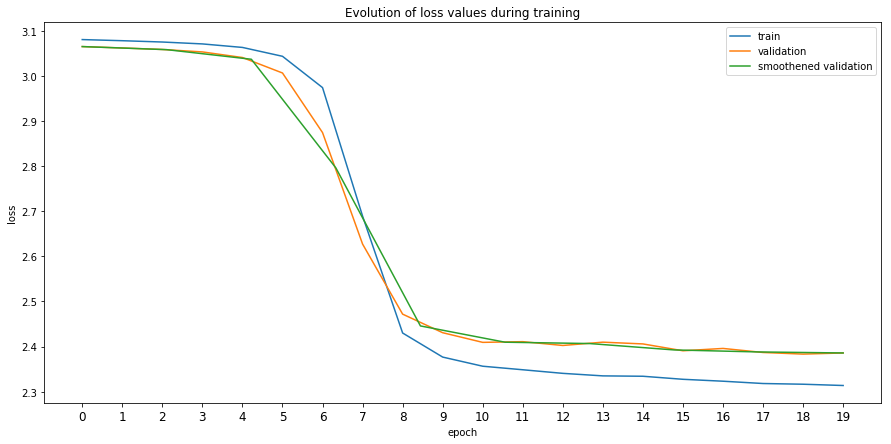

In [62]:
# Interpolate a smooth curve from the raw validation loss
n_epochs = len(history.history['val_loss'])
x_smooth = np.linspace(0, n_epochs-1, num=10)
y_smooth = spline(range(n_epochs), history.history['val_loss'], x_smooth)

plt.figure(figsize=(15, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(x_smooth, y_smooth)
plt.title('Evolution of loss values during training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(fontsize=12)
plt.axes().xaxis.set_major_locator(MultipleLocator(1))
plt.legend(['train', 'validation', 'smoothened validation'], loc='upper right')
plt.show()

In [63]:
data = load_data()

In [64]:
data.train.head(3)

,Unnamed: 0,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE,START_LAT,START_LONG,QUARTER_HOUR,DAY_OF_WEEK,WEEK_OF_YEAR,DURATION,ORIGIN_CALL_ENCODED,TAXI_ID_ENCODED,ORIGIN_STAND_ENCODED,POLYLINE_FULL
18067,1241746,1396007001620000267,A,2002.0,NaN,20000267,2014-03-28 11:43:21,"[(41.159646, -8.681697), (41.159574, -8.681868...",41.159646,-8.681697,46.866667,4,12,1800,2,172,0,"[(41.159646, -8.681697), (41.159574, -8.681868..."
20217,1379875,1398602704620000612,B,NaN,34.0,20000612,2014-04-27 12:45:04,"[(41.140827, -8.615538), (41.140575, -8.61624)...",41.140827,-8.615538,51.000000,6,16,345,0,384,34,"[(41.140827, -8.615538), (41.140575, -8.61624)..."
8023,544123,1382741020620000665,C,NaN,NaN,20000665,2013-10-25 22:43:40,"[(41.140863, -8.610129), (41.140854, -8.610111...",41.140863,-8.610129,90.866667,4,42,990,0,409,0,"[(41.140863, -8.610129), (41.140854, -8.610111..."
